In [ ]:
!pip install pyspark

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName('appName').setMaster('local')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [ ]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
import pyarrow as pa
from pyarrow import csv
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%matplotlib inline

In [ ]:
textFile = sc.textFile('cleaned_dataset.csv')
textFileRDD = textFile.map(lambda x: x.split(','))
header = textFileRDD.first()
textRDD = textFileRDD.filter(lambda r: r != header)

In [ ]:
def parse(r):
    try:
        x=Row(Year=int(r[0]),\
          Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          DepTime=int(float(r[8])), \
          CRSDepTime=int(r[7]),\
          ArrTime=int(float(r[11])),\
          CRSArrTime=int(r[10]), \
          UniqueCarrier=r[4],\
          DepDelay=int(float(r[9])),\
          Origin=r[5],\
          Dest=r[6], \
          Distance=int(float(r[12])),\
          CarrierDelay=int(float(r[13])),\
          WeatherDelay=int(float(r[14])),\
          NASDelay= int(float(r[15])),\
          SecurityDelay=int(float(r[16])),\
          LateAircraftDelay=int(float(r[17])))
    except:
        x=None
    return x

rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
sqlContext = SQLContext(sc)
airline_df = sqlContext.createDataFrame(rowRDD)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Add Hour of Day feature from CRSDepTime
airline_df = airline_df.withColumn("Hour", (col("CRSDepTime") / 100).cast("int"))

# Add a Weekend feature (1 for weekend, 0 for weekday)
airline_df = airline_df.withColumn("IsWeekend", when(col("DayOfWeek").isin([6, 7]), 1).otherwise(0))

# Add a Season feature
airline_df = airline_df.withColumn("Season", when(col("Month").isin([12, 1, 2]), "Winter")
                                   .when(col("Month").isin([3, 4, 5]), "Spring")
                                   .when(col("Month").isin([6, 7, 8]), "Summer")
                                   .when(col("Month").isin([9, 10, 11]), "Fall"))

In [ ]:
airline_df = airline_df.withColumn('DepDelayed', when(airline_df['DepDelay'] > 15, 1).otherwise(0))

In [ ]:
# define hour function to obtain hour of day
def hour_ex(x):
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF
sqlContext.udf.register("hour_ex_py",hour_ex, IntegerType())
f_udf = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f_udf(airline_df.CRSDepTime))
airline_df.registerTempTable("airlineDF")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [ ]:
# Check class distribution
class_distribution = airline_df.groupBy("DepDelayed").count().toPandas()
print(class_distribution)

   DepDelayed    count
0           1  1147992
1           0  4542191


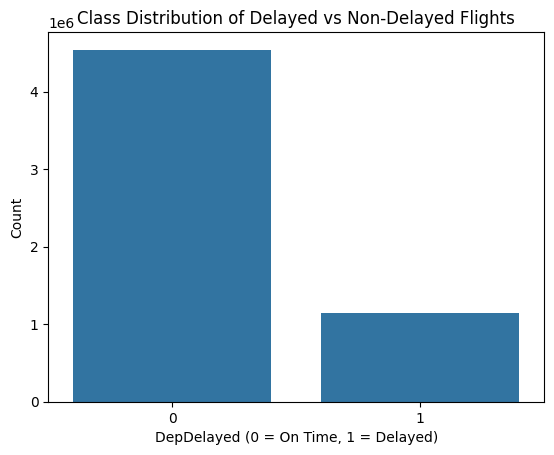

In [ ]:
# Convert Spark DataFrame to Pandas
class_distribution = airline_df.groupBy("DepDelayed").count().toPandas()

# Plotting distribution
sns.barplot(x="DepDelayed", y="count", data=class_distribution)
plt.title("Class Distribution of Delayed vs Non-Delayed Flights")
plt.xlabel("DepDelayed (0 = On Time, 1 = Delayed)")
plt.ylabel("Count")
plt.show()

In [ ]:
# Filter the delayed and non-delayed flights
delayed_df = airline_df.filter(airline_df["DepDelayed"] == 1)  # Flights that are delayed
on_time_df = airline_df.filter(airline_df["DepDelayed"] == 0)  # Flights that are not delayed

# Count the number of delayed and non-delayed flights
on_time_count = on_time_df.count()   
delayed_count = delayed_df.count()   

# Oversample the delayed class to match the non-delayed class
oversampled_delayed_df = delayed_df.sample(True, fraction=(on_time_count / delayed_count), seed=42)

# Combine the oversampled delayed class with the non-delayed class
balanced_airline_df = on_time_df.union(oversampled_delayed_df)

# Check the new distribution
balanced_airline_df.groupBy("DepDelayed").count().show()

+----------+-------+
|DepDelayed|  count|
+----------+-------+
|         0|4542191|
|         1|4539355|
+----------+-------+



In [ ]:
# Index and encode categorical variables
indexer_carrier = StringIndexer(inputCol="UniqueCarrier", outputCol="UniqueCarrierIndex")
encoder_carrier = OneHotEncoder(inputCol="UniqueCarrierIndex", outputCol="UniqueCarrierVec")

indexer_origin = StringIndexer(inputCol="Origin", outputCol="OriginIndex")
encoder_origin = OneHotEncoder(inputCol="OriginIndex", outputCol="OriginVec")

indexer_dest = StringIndexer(inputCol="Dest", outputCol="DestIndex")
encoder_dest = OneHotEncoder(inputCol="DestIndex", outputCol="DestVec")

# Additional features: Add temporal and weather-related features
balanced_airline_df = balanced_airline_df.withColumn("Month", col("Month").cast("int"))
balanced_airline_df = balanced_airline_df.withColumn("DayOfWeek", col("DayOfWeek").cast("int"))
balanced_airline_df = balanced_airline_df.withColumn("WeatherDelay", col("WeatherDelay").cast("int"))

# Assemble features including the new temporal and weather-related features
assembler = VectorAssembler(
    inputCols=["hour", "Distance", "UniqueCarrierVec", "OriginVec", "DestVec", "Month", "DayOfWeek", "WeatherDelay"],
    outputCol="features"
)

pipeline = Pipeline(stages=[
    indexer_carrier, encoder_carrier,
    indexer_origin, encoder_origin,
    indexer_dest, encoder_dest,
    assembler
])

model = pipeline.fit(balanced_airline_df)
balanced_airline_df = model.transform(balanced_airline_df)

In [ ]:
print(balanced_airline_df.columns)

['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'DepDelay', 'Origin', 'Dest', 'Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'hour', 'IsWeekend', 'Season', 'DepDelayed', 'UniqueCarrierIndex', 'UniqueCarrierVec', 'OriginIndex', 'OriginVec', 'DestIndex', 'DestVec', 'features']


In [ ]:
train_data, test_data = balanced_airline_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
def calculate_metrics(predictions):
    
    metrics = predictions.groupBy("DepDelayed", "prediction").count().toPandas()

    print("Metrics DataFrame:\n", metrics)

    if metrics.empty:
        return 0.0, 0.0, 0.0, 0.0  

    TP = metrics[(metrics["DepDelayed"] == 1) & (metrics["prediction"] == 1)]["count"].sum()
    FP = metrics[(metrics["DepDelayed"] == 0) & (metrics["prediction"] == 1)]["count"].sum()
    FN = metrics[(metrics["DepDelayed"] == 1) & (metrics["prediction"] == 0)]["count"].sum()
    TN = metrics[(metrics["DepDelayed"] == 0) & (metrics["prediction"] == 0)]["count"].sum()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0.0

    return precision, recall, f1_score, accuracy

In [ ]:
lr = LogisticRegression(labelCol="DepDelayed", featuresCol="features")
lr_model = lr.fit(train_data)

In [ ]:
# Predict on train and test sets
train_predictions = lr_model.transform(train_data)
test_predictions = lr_model.transform(test_data)

# Evaluate AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol="DepDelayed", metricName="areaUnderROC")

train_auc = evaluator.evaluate(train_predictions)
test_auc = evaluator.evaluate(test_predictions)

print(f"Training AUC-ROC: {train_auc}")
print(f"Testing AUC-ROC: {test_auc}")

Training AUC-ROC: 0.7038384361170154
Testing AUC-ROC: 0.7040581326484249


In [ ]:
train_precision, train_recall, train_f1, train_accuracy = calculate_metrics(train_predictions)
test_precision, test_recall, test_f1, test_accuracy = calculate_metrics(test_predictions)

print(f"Training - Precision: {train_precision}, Recall: {train_recall}, F1: {train_f1}, Accuracy: {train_accuracy}")
print(f"Testing - Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}, Accuracy: {test_accuracy}")

Metrics DataFrame:
    DepDelayed  prediction    count
0           0         0.0  2366897
1           0         1.0  1267635
2           1         0.0  1287736
3           1         1.0  2343708
Metrics DataFrame:
    DepDelayed  prediction   count
0           0         0.0  591404
1           0         1.0  316255
2           1         0.0  321677
3           1         1.0  586234
Training - Precision: 0.6489851559378326, Recall: 0.6453928519894565, F1: 0.6471840190799482, Accuracy: 0.6483100136857044
Testing - Precision: 0.6495746762564419, Recall: 0.6456954481221177, F1: 0.6476292532037119, Accuracy: 0.648632660817264


In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="DepDelayed", metricName="areaUnderROC")

# CrossValidator
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3  # 3-fold cross-validation
)

In [ ]:
cv_model = crossval.fit(train_data)

In [ ]:
best_model = cv_model.bestModel

print("Best Model Parameters:")
print(f"  regParam: {best_model._java_obj.getRegParam()}")
print(f"  elasticNetParam: {best_model._java_obj.getElasticNetParam()}")
print(f"  maxIter: {best_model._java_obj.getMaxIter()}")

Best Model Parameters:
  regParam: 0.01
  elasticNetParam: 0.0
  maxIter: 50


In [ ]:
# Evaluate the best model on train and test sets using calculate_metrics
train_predictions = best_model.transform(train_data)
test_predictions = best_model.transform(test_data)

# Use the evaluator to calculate AUC-ROC for both sets
train_auc = evaluator.evaluate(train_predictions)
test_auc = evaluator.evaluate(test_predictions)

# Calculate precision, recall, F1, and accuracy for train and test sets
train_precision, train_recall, train_f1, train_accuracy = calculate_metrics(train_predictions)
test_precision, test_recall, test_f1, test_accuracy = calculate_metrics(test_predictions)

print(f"Training Metrics (Tuned):")
print(f"AUC-ROC: {train_auc}")
print(f"Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}, Accuracy: {train_accuracy}")

print(f"Testing Metrics (Tuned):")
print(f"AUC-ROC: {test_auc}")
print(f"Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}, Accuracy: {test_accuracy}")

Metrics DataFrame:
    DepDelayed  prediction    count
0           0         0.0  2334939
1           0         1.0  1299593
2           1         0.0  1266221
3           1         1.0  2365223
Metrics DataFrame:
    DepDelayed  prediction   count
0           0         0.0  583342
1           0         1.0  324317
2           1         0.0  316241
3           1         1.0  591670
Training Metrics (Tuned):
AUC-ROC: 0.7007847299092509
Precision: 0.6453865623813038, Recall: 0.651317492435516, F1 Score: 0.6483384638157084, Accuracy: 0.6468727669895964
Testing Metrics (Tuned):
AUC-ROC: 0.7010266180206572
Precision: 0.6459371148280488, Recall: 0.65168281913095, F1 Score: 0.6487972463372403, Accuracy: 0.647186283095667


In [ ]:
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="DepDelayed",
    numTrees=50,
    seed=42
)

In [ ]:
model = rf.fit(train_data)

In [ ]:
predictions = model.transform(test_data)


evaluator = BinaryClassificationEvaluator(
    labelCol="DepDelayed",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
auc = evaluator.evaluate(predictions)
print(f"AUC-ROC: {auc}")
precision, recall, f1_score, accuracy = calculate_metrics(predictions)
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}, Accuracy: {train_accuracy}")

predictions.groupBy("DepDelayed", "prediction").count().show()

AUC-ROC: 0.6942528708033293
Metrics DataFrame:
    DepDelayed  prediction   count
0           0         0.0  481280
1           0         1.0  426379
2           1         0.0  232101
3           1         1.0  675810
Precision: 0.6131525536908824, Recall: 0.7443571010814937, F1-Score: 0.6724143077458832, Accuracy: 0.6468727669895964
+----------+----------+------+
|DepDelayed|prediction| count|
+----------+----------+------+
|         0|       0.0|481280|
|         0|       1.0|426379|
|         1|       0.0|232101|
|         1|       1.0|675810|
+----------+----------+------+

